## Summary

---

## Imports

In [52]:
import functools
import pickle
import shutil
from pathlib import Path

import elaspic2 as el2
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats
from sklearn import metrics, model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

In [4]:
pd.set_option("max_columns", 1000)
pd.set_option("max_rows", 1000)

## Parameters

In [5]:
NOTEBOOK_DIR = Path("38_cagi6_sherloc_train_model").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/38_cagi6_sherloc_train_model')

## Load data

In [6]:
submission_template_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "submission_template.tsv"
)

submission_template_df = pd.read_csv(submission_template_file, sep="\t")

display(submission_template_df.head(2))
len(submission_template_df)

hgvs score class comment
0  NM_152486.2:c.39C>T     *     *       *
1  NM_152486.2:c.62C>T     *     *       *

122124

### `training_df`

In [7]:
training_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc",
    "CAGI6-Sherloc-clinical-classification",
    "final_train_070821.txt",
)

In [8]:
training_all_df = pd.read_csv(training_file, sep="\t")

display(training_all_df.head(2))
len(training_all_df)

/home/strokach/envs/default-v46/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


chr     pos ref alt                  hgvs          interpretation  \
0   1  861332   G   A   NM_152486.2:c.11G>A  Uncertain significance   
1   1  865568   G   A  NM_152486.2:c.106G>A  Uncertain significance   

   Subcategory Missense  Subcategory Small intronic deletion or insertion  \
0                  True                                             False   
1                  True                                             False   

   Subcategory Small exonic in-frame deletion or insertion  
0                                              False        
1                                              False

418354

In [9]:
assert not set(submission_template_df["hgvs"]) & set(training_all_df["hgvs"])

In [10]:
training_df = training_all_df[training_all_df["Subcategory Missense"]]

display(training_df.head(2))
len(training_df)

chr     pos ref alt                  hgvs          interpretation  \
0   1  861332   G   A   NM_152486.2:c.11G>A  Uncertain significance   
1   1  865568   G   A  NM_152486.2:c.106G>A  Uncertain significance   

   Subcategory Missense  Subcategory Small intronic deletion or insertion  \
0                  True                                             False   
1                  True                                             False   

   Subcategory Small exonic in-frame deletion or insertion  
0                                              False        
1                                              False

217153

### `testing_df`

In [11]:
testing_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "CAGI6-Sherloc-clinical-classification", "final_test_070821.txt"
)

In [12]:
testing_all_df = pd.read_csv(testing_file, sep="\t")

display(testing_all_df.head(2))
len(testing_all_df)

/home/strokach/envs/default-v46/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


chr     pos ref alt                 hgvs  Subcategory Missense  \
0   1  861360   C   T  NM_152486.2:c.39C>T                 False   
1   1  861383   C   T  NM_152486.2:c.62C>T                  True   

   Subcategory Small intronic deletion or insertion  \
0                                             False   
1                                             False   

   Subcategory Small exonic in-frame deletion or insertion  
0                                              False        
1                                              False

122124

In [13]:
assert not set(submission_template_df["hgvs"]) ^ set(testing_all_df["hgvs"])

In [14]:
testing_df = testing_all_df[testing_all_df["Subcategory Missense"]]

display(testing_df.head(2))
len(testing_df)

chr     pos ref alt                  hgvs  Subcategory Missense  \
1   1  861383   C   T   NM_152486.2:c.62C>T                  True   
7   1  865640   G   A  NM_152486.2:c.178G>A                  True   

   Subcategory Small intronic deletion or insertion  \
1                                             False   
7                                             False   

   Subcategory Small exonic in-frame deletion or insertion  
1                                              False        
7                                              False

47103

### `validation_df`

In [15]:
validation_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "validation_variants.tsv"
)

In [16]:
validation_all_df = pd.read_csv(validation_file, sep="\t").rename(
    columns={"HGVS.c": "hgvs_g"}
)

display(validation_all_df.tail(2))
len(validation_all_df)

hgvs_g
17812           NC_000023.10:g.32519861C>T
17813  NC_000015.9:g.85406864_85406865insT

17814

In [17]:
def map_g_to_c(str_g, mapper):
    from hgvs.exceptions import HGVSInvalidIntervalError, HGVSUsageError

    var_g = hp.parse_hgvs_variant(str_g)
    for tx_ac in mapper.relevant_transcripts(var_g):
        try:
            var_c = mapper.g_to_c(var_g, tx_ac)
        except (HGVSUsageError, HGVSInvalidIntervalError):
            continue
        yield var_c

In [18]:
validation_mapping_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "validation-mapping-grch37.parquet"
)

if validation_mapping_file.is_file():
    validation_mapping_df = pq.read_table(validation_mapping_file).to_pandas()
else:
    import hgvs.assemblymapper
    import hgvs.dataproviders.uta
    import hgvs.parser

    hp = hgvs.parser.Parser()
    hdp = hgvs.dataproviders.uta.connect()
    mapper = hgvs.assemblymapper.AssemblyMapper(
        hdp, assembly_name="GRCh37", normalize=False
    )

    results = []
    for tup in tqdm(validation_all_df.itertuples(), total=len(validation_all_df)):
        for var_c in map_g_to_c(tup.hgvs_g, mapper):
            results.append((tup.str_g, str(var_c)))
    validation_mapping_df = pd.DataFrame(results, columns=["hgvs_g", "hgvs"])
    pq.write_table(
        pa.Table.from_pandas(validation_mapping_df, preserve_index=False),
        validation_mapping_file,
    )

In [19]:
display(validation_mapping_df.head(2))
print(len(validation_mapping_df))

hgvs_g                         hgvs
0  NC_000002.11:g.152537358A>G  NM_001164508.1:c.2944-16T>C
1  NC_000002.11:g.152537358A>G     NM_004543.4:c.2944-16T>C

67819


In [20]:
validation_df = (
    validation_all_df
    #
    .merge(validation_mapping_df, on=["hgvs_g"], how="left")
)

In [21]:
display(validation_df.tail(2))
print(len(validation_df))
print(len(validation_df["hgvs_g"].unique()))

hgvs_g                         hgvs
67830           NC_000023.10:g.32519861C>T     NM_004010.3:c.2011+11G>A
67831  NC_000015.9:g.85406864_85406865insT  NM_020778.4:c.5098_5099insT

67832
17814


## Load results

In [22]:
DATASET_NAME = "cagi6-sherloc"

DATASET_NAME

'cagi6-sherloc'

In [23]:
input_file = NOTEBOOK_DIR.parent.joinpath(
    "37_cagi6_sherloc_combine_results", "combined-results.parquet"
)

input_file

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/37_cagi6_sherloc_combine_results/combined-results.parquet')

In [24]:
result_df = pq.read_table(input_file).to_pandas()

display(result_df.head(2))
print(len(result_df))

protein_id mutation          mutation_id                  effect  \
0     P26678      R9C  NM_002667.3:c.25C>T              Pathogenic   
1     P26678      T8P  NM_002667.3:c.22A>C  Uncertain significance   

   proteinsolver_core_score_wt  \
0                     0.091593   
1                     0.041601   

              proteinsolver_core_features_residue_wt  \
0  [0.48249053955078125, 0.24484702944755554, -0....   
1  [2.043767213821411, 0.9361261129379272, -0.415...   

              proteinsolver_core_features_protein_wt  protbert_core_score_wt  \
0  [-2.27313494682312, 0.6932704448699951, -0.195...                0.068529   
1  [-2.27313494682312, 0.6932705044746399, -0.195...                0.062104   

                   protbert_core_features_residue_wt  \
0  [0.15305250883102417, -0.11011786758899689, 0....   
1  [0.056363195180892944, -0.020384633913636208, ...   

                   protbert_core_features_protein_wt  msa_count_wt  \
0  [0.05504663661122322, -0.04564127326011658, 0....          87.0   
1  [0.05504663661122322, -0.04564127326011658, 0....          95.0   

   msa_count_total  msa_proba_wt  msa_proba_total  msa_length  msa_proba  \
0            100.0     -0.310155       -88.633441       101.0  -0.536553   
1            100.0     -0.223144       -89.393727       101.0  -0.536553   

      msa_H    msa_KL  rosetta_cart_bonded_wt  rosetta_rama_prepro_wt  \
0  0.326639  2.625994               34.796667               18.080333   
1  0.074447  2.917469               35.531000               17.849000   

   rosetta_ref_wt  rosetta_hxl_tors_wt  rosetta_p_aa_pp_wt  \
0           13.08             5.875333           -4.878333   
1           13.08             9.764000           -5.052000   

   rosetta_fa_dun_semi_wt  rosetta_fa_dun_rot_wt  rosetta_fa_dun_dev_wt  \
0               33.826333                 30.420              37.201667   
1               33.549000                 30.357              43.524000   

   rosetta_omega_wt  rosetta_dslf_fa13_wt  rosetta_hbond_sc_wt  \
0         16.900333                   0.0                  0.0   
1         16.889000                   0.0                  0.0   

   rosetta_hbond_bb_sc_wt  rosetta_hbond_lr_bb_wt  rosetta_hbond_sr_bb_wt  \
0                  -0.495                     0.0                 -46.239   
1                  -0.743                     0.0                 -45.885   

   rosetta_fa_intra_elec_wt  rosetta_fa_elec_wt  \
0                    -5.748          -96.294333   
1                    -4.684          -97.176000   

   rosetta_lk_ball_bridge_uncpl_wt  rosetta_lk_ball_bridge_wt  \
0                        -1.515667                  -0.220333   
1                        -1.163000                  -0.196000   

   rosetta_lk_ball_iso_wt  rosetta_lk_ball_wt  rosetta_fa_intra_sol_xover4_wt  \
0             -145.437333          123.757667                       12.501667   
1             -144.679000          123.189000                       12.223000   

   rosetta_fa_intra_rep_xover4_wt  rosetta_fa_intra_atr_xover4_wt  \
0                        9.146667                      -22.659333   
1                        9.169000                      -22.419000   

   rosetta_fa_sol_wt  rosetta_fa_rep_wt  rosetta_fa_atr_wt  rosetta_dg_wt  \
0         279.312667             18.309        -311.028667         -1.308   
1         278.164000             18.065        -310.411000          8.945   

   rosetta_cart_bonded_change  rosetta_rama_prepro_change  rosetta_ref_change  \
0                   -0.577667                    0.614667               4.553   
1                   12.124333                    2.623000              -3.697   

   rosetta_hxl_tors_change  rosetta_p_aa_pp_change  \
0                 0.021333                0.376000   
1                -2.731667                0.545667   

   rosetta_fa_dun_semi_change  rosetta_fa_dun_rot_change  \
0                    0.173000                  -1.592000   
1                    1.057667               

221816


## Exploratory data analysis

In [25]:
proteinsolver_columnms = [c for c in result_df if c.startswith("proteinsolver_")]
protbert_columns = [c for c in result_df if c.startswith("protbert_")]
rosetta_columns = [c for c in result_df if c.startswith("rosetta_")]
alphafold_columns = [c for c in result_df if c.startswith("alphafold_")]

In [26]:
result_df["effect"].value_counts()

Uncertain significance    147067
Likely benign              11398
Benign                      9730
Pathogenic                  5834
Likely pathogenic           2506
Name: effect, dtype: int64

In [27]:
effect_map = {
    "Uncertain significance": 0,
    "Likely benign": -1,
    "Benign": -2,
    "Likely pathogenic": 1,
    "Pathogenic": 2,
}

result_df["effect_score"] = result_df["effect"].map(effect_map)

In [28]:
score_columns = [
    "el2_score",
    "proteinsolver_core_score_change",
    "protbert_core_score_change",
    "rosetta_dg_change",
    "alphafold_core_scores_residue_plddt_wt",
    "alphafold_core_scores_proten_ptm_wt",
    #         "alphafold_core_scores_residue_plddt_change",
    #         "alphafold_core_scores_protein_max_predicted_aligned_error_wt",
]

df = result_df.dropna(subset=score_columns + ["effect_score"])
df = df[df["effect_score"] != 0].reset_index(drop=True)

for col in score_columns:
    corr = stats.spearmanr(df["effect_score"], df[col])
    auc = metrics.roc_auc_score(df["effect_score"] > 0, df[col])
    precision = metrics.average_precision_score(df["effect_score"] > 0, df[col])
    print(col, corr[0], auc, precision)

el2_score 0.5009009313320716 0.8733030112155488 0.7773879717978156
proteinsolver_core_score_change 0.29156189775258534 0.712874183165052 0.5309820234848692
protbert_core_score_change 0.42966405016149745 0.8192752936611206 0.7443576566630334
rosetta_dg_change 0.24768921716995493 0.6824360622464656 0.5246370971798425
alphafold_core_scores_residue_plddt_wt 0.3201612581463264 0.7395894013695242 0.49606280549256343
alphafold_core_scores_proten_ptm_wt 0.19022844238168707 0.6415574636833643 0.41509543118588127


In [29]:
score_columns = [
    "el2_score",
    "proteinsolver_core_score_change",
    "protbert_core_score_change",
    "msa_KL",
    "rosetta_dg_change",
    "alphafold_core_scores_residue_plddt_wt",
    "alphafold_core_scores_residue_plddt_change",
#         "alphafold_core_scores_protein_plddt_wt",
#         "alphafold_core_scores_protein_max_predicted_aligned_error_wt",
#         "alphafold_core_scores_proten_ptm_wt",
]

for column in score_columns:
    print(f"{column} {result_df[column].isnull().sum()}")

el2_score 23
proteinsolver_core_score_change 0
protbert_core_score_change 23
msa_KL 569
rosetta_dg_change 714
alphafold_core_scores_residue_plddt_wt 95
alphafold_core_scores_residue_plddt_change 93824


## Train ML model

### Prepare dataset

In [40]:
rosetta_columns = [c for c in result_df if "rosetta" in c]
msa_columns = [c for c in result_df if c.startswith("msa")]

len(rosetta_columns), len(msa_columns)

(54, 10)

In [31]:
alphafold_columns = [
    "alphafold_core_scores_residue_plddt_wt",
    "alphafold_core_scores_proten_ptm_wt",
]

In [32]:
scalar_features = (
    [
        #     "el2_score",
        "proteinsolver_core_score_wt",
        "proteinsolver_core_score_change",
        "protbert_core_score_wt",
        "protbert_core_score_change",
    ]
    + msa_columns
    + rosetta_columns
    + alphafold_columns
)

vector_features = [
    "aa_wt_onehot",
    "aa_mut_onehot",
    "protbert_core_features_residue_wt",
    "protbert_core_features_residue_change",
    "proteinsolver_core_features_residue_wt",
    "proteinsolver_core_features_residue_change",
    #     "protbert_core_features_protein_wt",
    #     "protbert_core_features_protein_change",
    #     "proteinsolver_core_features_protein_wt",
    #     "proteinsolver_core_features_protein_change",
    #
    # AlphaFold
    "alphafold_core_features_residue_experimentally_resolved_wt",  # 0.19 [37]
    #     "alphafold_core_features_residue_experimentally_resolved_change",  # 0.11 [37]
    "alphafold_core_features_residue_predicted_lddt_wt",  # 0.17 [50]
    #     "alphafold_core_features_residue_predicted_lddt_change",  # 0.04 [50]
    "alphafold_core_features_residue_msa_first_row_wt",  # 0.17 [256]
    #     "alphafold_core_features_residue_msa_first_row_change",  # 0.21 [256]
    "alphafold_core_features_residue_single_wt",  # 0.20 [384]
    #     "alphafold_core_features_residue_single_change",  # 0.15 [384]
    "alphafold_core_features_residue_structure_module_wt",  # 0.18 [384]
    #     "alphafold_core_features_residue_structure_module_change",  # 0.05 [384]
]


df = (
    result_df.dropna(
        subset=scalar_features
        + vector_features
        + [
            "effect_score",
        ]
    )
    .drop_duplicates(subset=["protein_id", "mutation"])
    .sample(frac=1, random_state=0)
    .reset_index(drop=True)
)
df = df[df["effect_score"] != 0].reset_index(drop=True)


X_ref = np.c_[
    df[scalar_features].values,
    np.hstack([np.vstack(df[col].values) for col in vector_features]),
]
X = X_ref
# X = X[:, important_features]

low_confidence_mask = df["effect_score"] == 0

y = (df["effect_score"] > 0).values.astype(int)
y[low_confidence_mask] = (df[low_confidence_mask]["el2_score"] > 2).values.astype(int)
# y = df["effect_score"].values

weights = np.ones(len(df), dtype=np.float64)
weights[df["effect_score"] == 1] = 0.5
weights[df["effect_score"] == -1] = 0.5
weights[low_confidence_mask] = 0.05

In [33]:
df["effect_score"].value_counts()

-1.0    11305
-2.0     9630
 2.0     5731
 1.0     2480
Name: effect_score, dtype: int64

In [34]:
from collections import Counter

Counter(y)

Counter({0: 20935, 1: 8211})

### Hyperparameter optimization

In [35]:
CONST_PARAM = {
    "objective": "binary",
    "metric": "average_precision",
}

In [36]:
def training_loop(X, y, weights, param, n_splits=6, progressbar=False):
    models = []
    preds = np.ones(len(y), dtype=np.float64) * np.nan
    gkf = GroupKFold(n_splits=n_splits)
    for train_index, test_index in tqdm(
        gkf.split(X, y, groups=df["protein_id"]),
        total=n_splits,
        disable=not progressbar,
    ):
        X_training, X_testing = X[train_index], X[test_index]
        y_training, y_testing = y[train_index], y[test_index]
        weights_training, weights_testing = weights[train_index], weights[test_index]

        dtrain = lgb.Dataset(X_training, label=y_training, weight=weights_training)
        model = lgb.train(param, dtrain)
        preds[test_index] = model.predict(X_testing)
        models.append(model)
    return models, preds

In [37]:
def objective(trial, X, y, weights, low_confidence_mask):
    param = CONST_PARAM | {
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 64),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 60),
    }
    models, preds = training_loop(X, y, weights, param)
    pred_labels = np.rint(preds)
    accuracy = metrics.accuracy_score(
        y[~low_confidence_mask], pred_labels[~low_confidence_mask]
    )
    auc = metrics.roc_auc_score(y[~low_confidence_mask], preds[~low_confidence_mask])
    precision = metrics.average_precision_score(y[~low_confidence_mask], preds[~low_confidence_mask])
    return precision

In [38]:
# study = optuna.create_study(direction="maximize")
# study.optimize(lambda trial: objective(trial, X, y, weights, low_confidence_mask), n_trials=100)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)

In [39]:
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)

When optimizing avg. precision:

```json

```

When optimizing AUC:

```json
Number of finished trials: 100
Best trial: {'lambda_l1': 5.233219055743764, 'lambda_l2': 0.00037944276593632404, 'num_leaves': 64, 'feature_fraction': 0.5395906681722488, 'bagging_fraction': 0.9467711664385872, 'bagging_freq': 5, 'min_child_samples': 15}

```

### Checkpoint model

In [41]:
param = CONST_PARAM | {
    "lambda_l1": 0.0002981486679234547,
    "lambda_l2": 0.0002673369004197795,
    "num_leaves": 50,
    "feature_fraction": 0.4096898749114803,
    "bagging_fraction": 0.9608540739201844,
    "bagging_freq": 4,
    "min_data_in_leaf": 57,
}


models, preds = training_loop(X, y, weights, param, progressbar=True)

corr = stats.spearmanr(y[~low_confidence_mask], preds[~low_confidence_mask])
auc = metrics.roc_auc_score(y[~low_confidence_mask], preds[~low_confidence_mask])
precision = metrics.average_precision_score(y[~low_confidence_mask], preds[~low_confidence_mask])
print(corr[0], auc, precision)

  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 888495
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 888499
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


In [ ]:
# 0.6937225666428444 0.9451954788366176

In [ ]:
# Compare effect of weighting when using EL2 to label uncertain mutations
# (weights for: 1, -1, 0)
# 0.634985235753114 0.9065879781245562 (0.5, 0.5, 0.5)
# 0.6461637973791433 0.9137457331619272 (0.5, 0.5, 0.1)
# 0.6499893944121155 0.9161953047033986 (0.5, 0.5, 0.05) ★
# 0.6496451717121724 0.9159748951509965 (0.5, 0.5, 0.01)

### Feature elimination

In [44]:
def get_feature_index(num_features, features_to_exclude):
    idx = 0
    seen = set(features_to_exclude)
    indices = list(reversed(range(num_features)))
    while indices:
        idx = indices.pop()
        while idx in seen:
            idx += 1
        seen.add(idx)
        yield idx


list(get_feature_index(10, {1, 2, 3, 9, 10}))

[0, 4, 5, 6, 7, 8, 11, 12, 13, 14]

In [ ]:
feature_elimination_stats_file = NOTEBOOK_DIR.joinpath("feature-elimination-stats.pickle")
feature_elimination_stats_file.touch()

features_to_exclude = {}

fe_round = -1
fe_round_stats = []
while len(features_to_exclude) < X_ref.shape[1]:
    fe_round += 1

    # Apply feature elimination mask
    feature_mask = np.ones(X_ref.shape[1], dtype=bool)
    feature_mask[np.array(list(features_to_exclude), dtype=int)] = False
    X = X_ref[:, feature_mask]

    # Re-train models
    models, preds = training_loop(X, y, weights, param, progressbar=True)

    # Calculate model statistics
    corr = stats.spearmanr(y[~low_confidence_mask], preds[~low_confidence_mask])
    auc = metrics.roc_auc_score(y[~low_confidence_mask], preds[~low_confidence_mask])
    precision = metrics.average_precision_score(
        y[~low_confidence_mask], preds[~low_confidence_mask]
    )

    # Save stats
    round_stats = (
        fe_round,
        corr[0],
        auc,
        precision,
        len(features_to_exclude),
        X_ref.shape[1] - X.shape[1],
        list(features_to_exclude),
    )
    print(round_stats)
    fe_round_stats.append(round_stats)
    shutil.copyfile(
        feature_elimination_stats_file, feature_elimination_stats_file.with_suffix(".pickle.bak")
    )
    with feature_elimination_stats_file.open("wb") as fout:
        pickle.dump(fe_round_stats, fout, pickle.HIGHEST_PROTOCOL)

    # Find new features to eliminate
    feature_importance_split = np.vstack(
        [model.feature_importance("split") for model in models]
    ).sum(axis=0)
    feature_importance_gain = np.vstack([model.feature_importance("gain") for model in models]).sum(
        axis=0
    )

    feature_df = pd.DataFrame(
        {
            "feature_idx": list(
                get_feature_index(len(feature_importance_split), features_to_exclude)
            ),
            "feature_importance_split": feature_importance_split,
            "feature_importance_gain": feature_importance_gain,
        }
    )

    min_split = feature_df["feature_importance_split"].min()
    feature_df = feature_df[feature_df["feature_importance_split"] == min_split]
    min_gain = feature_df["feature_importance_gain"].min()
    feature_df = feature_df[feature_df["feature_importance_gain"] == min_gain]
    new_features_to_exclude = feature_df["feature_idx"].values.tolist()

    for feature_idx in new_features_to_exclude:
        assert feature_idx not in features_to_exclude
        features_to_exclude[feature_idx] = fe_round

#     break
#     if (feature_df["feature_importance_split"] == 0

  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 888495
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 888499
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851954
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3343
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851958
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3343
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827217
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3245
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827221
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3245
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804265
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804269
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782080
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3067
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782084
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 3067
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 762445
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2990
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 762449
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2990
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 745105
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2922
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 745109
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2922
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730570
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2865
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730574
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2865
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720115
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2824
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720119
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2824
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 708130
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2777
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 708134
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2777
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694615
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2724
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694619
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2724
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683905
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2682
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683909
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2682
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 675490
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2649
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 675494
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2649
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666055
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2612
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666059
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2612
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 658405
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 658409
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652030
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652034
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644890
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2529
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644894
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2529
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636730
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2497
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636734
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2497
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 631885
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2478
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 631889
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2478
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624490
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2449
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624494
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2449
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 619390
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2429
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 619394
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2429
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 613015
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2404
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 613019
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2404
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 608170
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2385
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 608174
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2385
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603580
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2367
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603584
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2367
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 599500
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 599504
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 596695
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 596699
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2340
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 590830
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2317
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 590834
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2317
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 588790
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2309
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 588794
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2309
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 586240
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 586244
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 583690
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2289
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 583694
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2289
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579610
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2273
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579614
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2273
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575020
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2255
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575024
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2255
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573235
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2248
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573239
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2248
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571195
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571199
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568390
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2229
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568394
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2229
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564310
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564314
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 563035
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 563039
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 559210
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 559214
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556405
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556409
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 555130
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 555134
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552325
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2166
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552329
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2166
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 550795
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 550799
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 548755
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 548759
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 545950
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 545954
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 544420
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 544424
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 541870
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 541874
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 539830
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 539834
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 538045
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 538049
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 536260
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 536264
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 534985
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2098
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 534989
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2098
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 532945
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2090
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 532949
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2090
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 530905
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2082
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 530909
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2082
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 529630
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2077
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 529634
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2077
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 527335
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2068
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 527339
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2068
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 526060
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2063
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 526064
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2063
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524530
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2057
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524534
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2057
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524275
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2056
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524279
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2056
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 523000
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 523004
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2051
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 521725
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2046
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 521729
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2046
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519685
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2038
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519689
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2038
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 517645
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2030
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 517649
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2030
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 515605
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2022
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 515609
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2022
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514840
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2019
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514844
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2019
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 513055
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2012
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 513059
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2012
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511780
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2007
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511784
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2007
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510760
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2003
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510764
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 2003
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509485
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509489
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 507955
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1992
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 507959
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1992
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 506680
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1987
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 506684
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1987
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 505915
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1984
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 505919
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1984
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503875
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1976
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503879
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1976
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 502855
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1972
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 502859
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1972
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 501580
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1967
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 501584
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1967
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 500050
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1961
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 500054
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1961
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498775
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1956
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498779
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1956
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 497755
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1952
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 497759
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1952
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 497245
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1950
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 497249
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1950
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496480
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1947
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496484
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1947
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493930
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1937
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493934
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1937
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 492655
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1932
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 492659
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1932
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 491380
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1927
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 491384
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1927
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 490870
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1925
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 490874
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1925
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 489340
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1919
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 489344
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1919
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 488575
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1916
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 488579
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1916
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 488320
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1915
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 488324
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1915
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 487555
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1912
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 487559
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1912
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 486025
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1906
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 486029
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1906
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484495
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1900
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484499
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1900
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 483475
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1896
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 483479
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1896
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 482710
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1893
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 482714
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1893
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 481435
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1888
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 481439
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1888
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480670
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1885
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480674
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1885
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 479140
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 479144
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 478120
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 478124
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1875
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 477865
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1874
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 477869
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1874
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476845
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1870
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476849
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1870
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476335
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1868
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476339
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1868
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 475570
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1865
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 475574
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1865
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 475315
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1864
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 475319
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1864
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473785
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473789
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473530
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473534
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473020
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1855
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473024
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1855
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 472765
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1854
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 472769
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1854
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 471745
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1850
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 471749
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1850
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 470215
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1844
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 470219
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1844
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 469705
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1842
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 469709
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1842
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468685
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1838
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468689
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1838
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 467665
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1834
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 467669
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1834
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 467155
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1832
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 467159
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1832
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 466900
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1831
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 466904
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1831
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 465625
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1826
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 465629
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1826
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 465370
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1825
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 465374
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1825
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 464605
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1822
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 464609
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1822
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 464350
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1821
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 464354
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1821
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 462820
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1815
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 462824
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1815
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 462310
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1813
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 462314
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1813
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461800
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1811
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461804
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1811
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461290
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1809
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461294
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1809
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 460525
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1806
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 460529
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1806
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 460015
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1804
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 460019
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1804
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 458995
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1800
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 458999
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1800
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 457975
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1796
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 457979
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1796
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456955
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1792
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456959
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1792
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456445
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1790
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456449
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1790
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456190
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1789
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456194
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1789
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455935
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1788
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455939
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1788
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455425
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455429
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455170
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1785
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455174
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1785
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 453385
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1778
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 453389
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1778
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 452875
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 452879
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 452365
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1774
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 452369
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1774
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 452110
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1773
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 452114
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1773
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 451855
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1772
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 451859
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1772
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 451600
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1771
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 451604
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1771
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 451090
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1769
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 451094
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1769
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450325
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1766
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450329
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1766
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450070
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1765
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450074
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1765
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 449305
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 449309
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 449050
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 449054
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1761
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448795
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448799
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448030
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448034
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 447775
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1756
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 447779
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1756
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 447520
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1755
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 447524
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1755
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446500
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1751
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446504
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1751
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445990
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1749
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445994
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1749
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445735
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445739
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445480
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1747
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445484
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1747
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444715
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1744
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444719
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1744
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 443950
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 443954
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1741
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 443695
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1740
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 443699
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1740
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 443440
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1739
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 443444
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1739
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442930
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1737
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442934
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1737
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442420
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1735
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442424
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1735
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441910
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1733
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441914
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1733
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441655
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1732
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441659
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1732
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441400
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1731
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441404
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1731
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441145
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441149
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 440890
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1729
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 440894
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1729
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 440380
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 440384
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 439615
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1724
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 439619
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1724
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 439105
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1722
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 439109
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1722
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438595
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1720
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438599
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1720
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 437575
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1716
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 437579
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1716
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436045
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1710
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436049
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1710
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435790
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1709
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435794
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1709
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434770
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1705
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434774
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1705
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434260
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1703
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434264
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1703
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434005
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1702
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434009
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1702
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 433750
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1701
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 433754
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1701
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 433495
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1700
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 433499
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1700
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432985
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432989
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432730
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1697
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432734
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1697
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432475
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1696
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432479
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1696
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432220
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1695
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432224
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1695
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431455
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1692
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431459
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1692
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431200
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1691
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431204
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1691
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430180
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1687
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430184
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1687
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429415
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1684
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429419
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1684
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428905
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1682
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428909
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1682
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428395
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1680
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428399
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1680
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428140
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1679
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428144
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1679
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427885
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1678
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427889
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1678
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427630
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1677
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427634
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1677
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427375
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1676
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427379
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1676
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427120
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1675
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427124
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1675
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426865
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1674
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426869
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1674
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426610
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1673
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426614
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1673
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426355
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1672
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426359
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1672
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426100
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1671
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426104
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1671
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 425845
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1670
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 425849
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1670
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 425590
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1669
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 425594
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1669
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 424825
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1666
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 424829
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1666
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 424570
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1665
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 424574
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1665
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 424315
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1664
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 424319
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1664
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 424060
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1663
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 424064
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1663
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423805
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1662
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423809
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1662
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423550
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1661
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423554
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1661
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423040
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1659
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423044
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1659
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 422530
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1657
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 422534
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1657
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 422020
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1655
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 422024
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1655
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421510
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1653
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421514
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1653
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421000
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1651
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421004
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1651
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 420490
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1649
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 420494
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1649
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 420235
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1648
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 420239
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1648
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419980
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1647
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419984
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1647
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419725
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1646
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419729
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1646
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419470
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1645
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419474
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1645
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419215
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1644
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 419219
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1644
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418705
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1642
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418709
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1642
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418450
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1641
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418454
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1641
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417940
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1639
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417944
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1639
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417685
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1638
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417689
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1638
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417430
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1637
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417434
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1637
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417175
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1636
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417179
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1636
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 416920
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1635
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 416924
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1635
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 416410
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1633
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 416414
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1633
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 416155
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1632
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 416159
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1632
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415900
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1631
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415904
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1631
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415645
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1630
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415649
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1630
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415390
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1629
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415394
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1629
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414880
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1627
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414884
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1627
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414625
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1626
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414629
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1626
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414370
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1625
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414374
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1625
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414115
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1624
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414119
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1624
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413350
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1621
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413354
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1621
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413095
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1620
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413099
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1620
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412585
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1618
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412589
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1618
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412330
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1617
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412334
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1617
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412075
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1616
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412079
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1616
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411820
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1615
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411824
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1615
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411565
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1614
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411569
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1614
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411310
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1613
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411314
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1613
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410800
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1611
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410804
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1611
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410545
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1610
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410549
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1610
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410290
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1609
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410294
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1609
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 409525
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1606
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 409529
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1606
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 409270
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1605
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 409274
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1605
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408760
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1603
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408764
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1603
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408505
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1602
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408509
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1602
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407995
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1600
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407999
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1600
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407740
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1599
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407744
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1599
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407485
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1598
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407489
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1598
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407230
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1597
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407234
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1597
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 406465
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1594
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 406469
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1594
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 406210
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1593
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 406214
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1593
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 405955
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1592
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 405959
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1592
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 405445
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1590
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 405449
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1590
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 405190
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1589
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 405194
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1589
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404680
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1587
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404684
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1587
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404425
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1586
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404429
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1586
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404170
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1585
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404174
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1585
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403660
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1583
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403664
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1583
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403405
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403409
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1582
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403150
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1581
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403154
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1581
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 402895
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1580
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 402899
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1580
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 402130
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1577
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 402134
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1577
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 401875
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1576
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 401879
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1576
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 401110
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1573
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 401114
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1573
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 400855
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1572
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 400859
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1572
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 400600
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 400604
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 400345
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1570
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 400349
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1570
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 400090
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 400094
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 399835
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1568
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 399839
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1568
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 399580
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1567
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 399584
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1567
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 399070
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1565
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 399074
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1565
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398815
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1564
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398819
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1564
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398560
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1563
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398564
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1563
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398050
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1561
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398054
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1561
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397795
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1560
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397799
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1560
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397540
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1559
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397544
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1559
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397030
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397034
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1557
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 396775
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1556
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 396779
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1556
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 396520
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1555
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 396524
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1555
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 396010
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1553
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 396014
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1553
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395755
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1552
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395759
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1552
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395245
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1550
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395249
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1550
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394990
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394994
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394735
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1548
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394739
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1548
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394225
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1546
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394229
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1546
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393970
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1545
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393974
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1545
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393715
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1544
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393719
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1544
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393460
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1543
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393464
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1543
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393205
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1542
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393209
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1542
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392695
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1540
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392699
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1540
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392440
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1539
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392444
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1539
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392185
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1538
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392189
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1538
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391930
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391934
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391675
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391679
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391420
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1535
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391424
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1535
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391165
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1534
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391169
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1534
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390910
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1533
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390914
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1533
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390655
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1532
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390659
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1532
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390400
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1531
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390404
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1531
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390145
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1530
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390149
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1530
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 389380
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1527
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 389384
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1527
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 389125
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1526
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 389129
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1526
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388870
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1525
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388874
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1525
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388615
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388619
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388360
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1523
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388364
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1523
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388105
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388109
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387850
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387854
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1521
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387595
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387599
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387340
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1519
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387344
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1519
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387085
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1518
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387089
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1518
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386830
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1517
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386834
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1517
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386575
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1516
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386579
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1516
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386320
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1515
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386324
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1515
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386065
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1514
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386069
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1514
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385810
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1513
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385814
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1513
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385300
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1511
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385304
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1511
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385045
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1510
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385049
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1510
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 384790
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1509
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 384794
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1509
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 384535
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1508
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 384539
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1508
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 384280
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1507
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 384284
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1507
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 384025
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1506
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 384029
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1506
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 383770
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1505
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 383774
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1505
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 383515
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1504
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 383519
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1504
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 383260
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1503
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 383264
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1503
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 383005
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1502
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 383009
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1502
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382750
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1501
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382754
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1501
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382495
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382499
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382240
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1499
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382244
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1499
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381985
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1498
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381989
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1498
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381730
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1497
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381734
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1497
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381475
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1496
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381479
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1496
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381220
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381224
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1495
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 380710
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1493
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 380714
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1493
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 380455
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1492
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 380459
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1492
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 380200
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1491
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 380204
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1491
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379945
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1490
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379949
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1490
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379690
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1489
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379694
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1489
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379435
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1488
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379439
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1488
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379180
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1487
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379184
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1487
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 378925
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1486
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 378929
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1486
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 378670
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1485
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 378674
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1485
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 378415
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 378419
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 378160
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1483
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 378164
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1483
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377905
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377909
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377650
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1481
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377654
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1481
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377395
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1480
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377399
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1480
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376885
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1478
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376889
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1478
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376630
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1477
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376634
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1477
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376375
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1476
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376379
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1476
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376120
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1475
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376124
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1475
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375865
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375869
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375610
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1473
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375614
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1473
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375355
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1472
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375359
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1472
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375100
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1471
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375104
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1471
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7026, number of negative: 17262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 374845
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1470
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322688 -> initscore=-0.741448
[LightGBM] [Info] Start training from score -0.741448
[LightGBM] [Info] Number of positive: 6848, number of negative: 17440
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 374849
[LightGBM] [Info] Number of data points in the train set: 24288, number of used features: 1470
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.312428 -> initscore=-0.788794
[LightGBM] [Info] Start training from score -0.788794


In [ ]:
(feature_importance_split == 0).sum()

### Checkpoint model

In [ ]:
feature_df

In [ ]:
# Play with weights
# # Remove 0 from training set
# 0.6445921081338579 0.9127408076311398
# 0.6449644074377229 0.9129791957737381 (weights: 0.5, 0.5) [0.6519079506754358 0.9174252378639102]
# 0.6445443685870316 0.9127102393712581 (weights: 0.4, 0.4)
# 0.6455538992488725 0.9133566551362649 (weights: 0.3, 0.3) [0.9171164733046693]
# 0.6452602748674968 0.9131686435817019 (weights: 0.2, 0.2)
# 0.6443443914762861 0.9125821913961814 (weights: 0.1, 0.1)


# # Keep 0 in training set
# 0.6279471936537289 0.9020828498944281
# 0.6443655135154522 0.9125957161157062 (weights: 1.0, 1.0, 0.05)
# 0.6472835979832177 0.9144642039931771 (weights: 1.0, 1.0, 0.01) ★
# 0.6460811745050736 0.9136942764200848 (weights: 0.5, 0.5, 0.01)
# 0.6440994599372241 0.9124253585091959 (weights: 0.5, 0.5, 0.05)

In [ ]:
# Rows with Rosetta features
# 0.6511097888905689 0.9069517496895931  (no Rosetta)
# 0.6660185149966301 0.9162698896991949  (all Rosetta columns)

In [ ]:
# Rows with AF features
# 0.6658121877163097 0.9006706783116625  (no AF)
# 0.6996884055147549 0.9210566180922061  (without AF changes)
# 0.7041584812816902 0.9237466083367306  (with AF changes)

In [ ]:
# Rows with both AF and Rosetta features
# 0.6598501937428695 0.8865273801086971
# 0.6724664771013962 0.8939177529532045  (with Rosetta)
# 0.7044603810803847 0.9126591582020247  (with AF and Rostta)

In [89]:
prediction_df = result_df.dropna(subset=scalar_features + vector_features).copy()


X = np.c_[
    prediction_df[scalar_features].values,
    np.hstack([np.vstack(prediction_df[col].values) for col in vector_features]),
]


for model_idx, model in enumerate(models):
    prediction_df[f"pred_{model_idx}"] = model.predict(X)

prediction_df["pred"] = prediction_df[
    [f"pred_{model_idx}" for model_idx in range(len(models))]
].mean(axis=1)

In [90]:
validation_submission_df = validation_df.assign(
    is_missense=lambda df: df["hgvs"].notnull()
).merge(prediction_df, left_on=["hgvs"], right_on=["mutation_id"], how="left")

assert len(validation_submission_df) == len(validation_df)

median = np.nanmedian(validation_submission_df["pred"])
print(f"{median=}")

out = (
    validation_submission_df.groupby("hgvs_g")
    .agg({"pred": np.nanmean, "is_missense": "max"})
    .fillna(median)
    .reset_index()
)

median_adj = median / out["pred"].max()
out["pred"] = out["pred"] / out["pred"].max()

out.head()

median=0.14638564933766038


hgvs_g      pred  is_missense
0                  NC_000001.10:g.10032239T>C  0.147822         True
1  NC_000001.10:g.100327066_100327067delinsAT  0.147822         True
2                 NC_000001.10:g.100329994A>G  0.147822         True
3                 NC_000001.10:g.100340374A>G  0.147822         True
4                 NC_000001.10:g.100340991A>G  0.147822         True

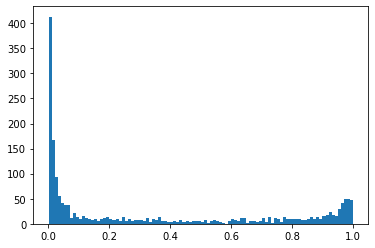

In [91]:
plt.hist(out[out["pred"] != median_adj]["pred"], bins=100)
None

In [74]:
out[["hgvs_g", "pred"]].to_csv(
    NOTEBOOK_DIR.joinpath("submission-valid-6.tsv"), index=False, sep="\t"
)

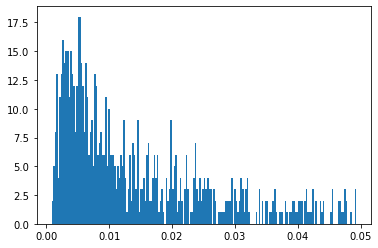

In [92]:
plt.hist(out[out["pred"] < 0.05]["pred"], bins=200)
None

In [ ]:
# 0.6516511403259807 0.9172607988182891 (without protein features)
# 0.6511556042045329 0.9169435005200913 (with protein features)

In [ ]:
# 0.6253383274259249 0.9004123585248509

# 0.21795514450655545 0.8581850558176667
# regression all: 0.22461305628504954 0.8288936050495531

In [ ]:
model

In [ ]:
clf.importance_type

In [ ]:
clf.feature_importances_

In [ ]:
clf.booster_.feature_importance()

In [ ]:
important_features = clf.booster_.feature_importance() > 0

In [ ]:
from collections import Counter

import matplotlib.pyplot as plt

importantces = np.array(clf.booster_.feature_importance("gain"))
importantces = np.clip(importantces, -1, 100)

plt.hist(importantces, bins=100)
None

In [ ]:
plt.plot(clf.feature_importances_, importantces, "r.")

In [ ]:
import sys

paths = [
    "/gpfs/fs0/scratch/p/pmkim/strokach/workspace/shap-0.39.0",
    "/gpfs/fs0/scratch/p/pmkim/strokach/workspace/shap-hypetune",
    "/gpfs/fs0/scratch/p/pmkim/strokach/workspace/slicer-0.0.7",
]
for p in paths:
    if p not in sys.path:
        sys.path.insert(0, p)

from lightgbm import LGBMClassifier
from scipy import stats
from shaphypetune import BoostBoruta, BoostRFE, BoostSearch

In [ ]:
param_grid = {
    "n_estimators": 150,
    "learning_rate": [0.2, 0.1],
    "num_leaves": [25, 30, 35],
    "max_depth": [10, 12],
}

model = BoostBoruta(
    LGBMClassifier(),
    param_grid=param_grid,
    max_iter=100,
    perc=100,
    importance_type="shap_importances",
    train_importance=False,
)
model.fit(
    X_training,
    y_training,
    eval_set=[(X_testing, y_testing)],
    early_stopping_rounds=6,
    verbose=0,
)

In [ ]:
import lightgbm as lgb
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

score_columns = [
    "el2_score",
    "proteinsolver_core_score_change",
    "protbert_core_score_change",
    #     "rosetta_dg_change",
    "alphafold_core_scores_residue_plddt_wt",
    #     "alphafold_core_scores_protein_plddt_wt",
    #     "alphafold_core_scores_protein_max_predicted_aligned_error_wt",
    #     "alphafold_core_scores_proten_ptm_wt",
]

col = "protbert_core_features_residue_change"

df = result_df.dropna(subset=score_columns + [col, "effect_score"]).sample(
    frac=1, random_state=0
)
df = df[df["effect_score"].isin([-1, 1])].reset_index(drop=True)

amino_acids = list("ARNDCEQGHILKMFPSTWYV")

df["aa_wt_onehot"] = pd.get_dummies(df["mutation"].str[0]).apply(list, axis=1)
df["aa_mut_onehot"] = pd.get_dummies(df["mutation"].str[0]).apply(list, axis=1)

df["preds"] = np.nan
df["pca_preds"] = np.nan

X = np.vstack(df[col].values)

Z = None
Z = np.c_[np.vstack(df["aa_wt_onehot"].values), np.vstack(df["aa_mut_onehot"].values)]
Z = np.c_[
    df[
        ["el2_score", "proteinsolver_core_score_change", "protbert_core_score_change"]
    ].values,
    Z,
]

y = (df["effect_score"] > 0).values.astype(int)


def select_features(X_training, X_testing):
    scaler = StandardScaler()
    scaler.fit(X_training)
    X_training = scaler.transform(X_training)
    X_testing = scaler.transform(X_testing)

    pca = PCA(0.9, svd_solver="full")
    pca.fit(X_training)
    X_training = pca.transform(X_training)
    X_testing = pca.transform(X_testing)
    return X_training, X_testing


params = dict()


n_splits = 6
gkf = GroupKFold(n_splits=n_splits)
for train_index, test_index in tqdm(
    gkf.split(X, y, groups=df["protein_id"]), total=n_splits
):
    X_training, X_testing = X[train_index], X[test_index]
    y_training, y_testing = y[train_index], y[test_index]
    if Z is not None:
        Z_training, Z_testing = Z[train_index], Z[test_index]
        X_training = np.c_[X_training, Z_training]
        X_testing = np.c_[X_testing, Z_testing]

    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_training, y_training, eval_set=[(X_testing, y_testing)], verbose=False)
    df.loc[test_index, "preds"] = clf.predict_proba(X_testing)[:, 1]

    X_training, X_testing = select_features(X[train_index], X[test_index])
    y_training, y_testing = y[train_index], y[test_index]
    if Z is not None:
        Z_training, Z_testing = Z[train_index], Z[test_index]
        X_training = np.c_[X_training, Z_training]
        X_testing = np.c_[X_testing, Z_testing]

    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_training, y_training, eval_set=[(X_testing, y_testing)], verbose=False)
    df.loc[test_index, "pca_preds"] = clf.predict_proba(X_testing)[:, 1]

corr = stats.spearmanr(df["effect_score"], df["preds"])
auc = metrics.roc_auc_score(df["effect_score"] > 0, df["preds"])
print(corr[0], auc)

corr = stats.spearmanr(df["effect_score"], df["pca_preds"])
auc = metrics.roc_auc_score(df["effect_score"] > 0, df["pca_preds"])
print(corr[0], auc)

In [ ]:
# 0.6585175611306802 0.88576012420753
# 0.6547985025461474 0.8835814968157445

In [ ]:
evals = []
for i in tqdm(range(X_training.shape[1])):
    x1 = X_training[:, i]

    corr = stats.spearmanr(df["effect_score"], x1)
    auc = metrics.roc_auc_score(df["effect_score"] > 0, x1)
    evals.append((i, *corr, auc))

evals_df = pd.DataFrame(evals, columns=["i", "corr", "pvalue", "auc"])
evals_df["corr_abs"] = evals_df["corr"].abs()
evals_df = evals_df.sort_values("corr_abs", ascending=False)
del evals_df["corr_abs"]

display(evals_df.head(10))

In [ ]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0
)

In [ ]:
train_result_df.head()

In [ ]:
import matplotlib.pyplot as plt

plt.hist(x1, bins=100)
plt.hist(x2, bins=100)

None

In [ ]:
x = df["alphafold_core_features_residue_experimentally_resolved_wt"].apply(np.mean)

corr = stats.spearmanr(df["effect_score"], x)
auc = metrics.roc_auc_score(df["effect_score"] > 0, x)

corr, auc

In [ ]:
import lightgbm as lgb

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

col = "alphafold_core_features_residue_msa_first_row_change"

x = np.vstack(df[col].values)
x = StandardScaler().fit_transform(x)
x = PCA(0.9, svd_solver="full").fit_transform(x)

evals = []
for i in tqdm(range(x.shape[1])):
    x1 = x[:, i]

    corr = stats.spearmanr(df["effect_score"], x1)
    auc = metrics.roc_auc_score(df["effect_score"] > 0, x1)
    evals.append((i, *corr, auc))

evals_df = pd.DataFrame(evals, columns=["i", "corr", "pvalue", "auc"])
evals_df["corr_abs"] = evals_df["corr"].abs()
evals_df = evals_df.sort_values("corr_abs", ascending=False)
del evals_df["corr_abs"]

display(evals_df.head(10))

In [ ]:
x.shape

In [ ]:
# col = "alphafold_core_features_residue_experimentally_resolved_wt"  # 0.19 [37]
# col = "alphafold_core_features_residue_experimentally_resolved_change"  # 0.11 [37]
# col = "alphafold_core_features_residue_predicted_lddt_wt"  # 0.17 [50]
# col = "alphafold_core_features_residue_predicted_lddt_change"  # 0.04 [50]
# col = "alphafold_core_features_residue_msa_first_row_wt"  # 0.17 [256]
# col = "alphafold_core_features_residue_msa_first_row_change"  # 0.21 [256]
# col = "alphafold_core_features_residue_single_wt"  # 0.20 [384]
# col = "alphafold_core_features_residue_single_change"  # 0.15 [384]
# col = "alphafold_core_features_residue_structure_module_wt"  # 0.18 [384]
col = "alphafold_core_features_residue_structure_module_change"  # 0.05 [384]

col = "protbert_core_features_residue_change"  # 0.13 [1024]

# col = "alphafold_core_features_protein_experimentally_resolved_wt"  #
# col = "alphafold_core_features_protein_predicted_lddt_wt"  #
# col = "alphafold_core_features_protein_msa_first_row_wt"  #
# col = "alphafold_core_features_protein_single_wt"  #
# col = "alphafold_core_features_protein_structure_module_wt"  #

num_features = len(result_df[col][0])

evals = []
for i in tqdm(range(num_features)):
    x1 = df[col].str[i]

    corr = stats.spearmanr(df["effect_score"], x1)
    auc = metrics.roc_auc_score(df["effect_score"] > 0, x1)
    evals.append((i, *corr, auc))

evals_df = pd.DataFrame(evals, columns=["i", "corr", "pvalue", "auc"])
evals_df["corr_abs"] = evals_df["corr"].abs()
evals_df = evals_df.sort_values("corr_abs", ascending=False)
del evals_df["corr_abs"]

display(evals_df.head(10))

In [ ]:
scores_proten_ptm

In [ ]:
validation_df.head()

In [ ]:
validation_submission_df = validation_df.assign(
    is_missense=lambda df: df["hgvs"].notnull()
).merge(result_df, left_on=["hgvs"], right_on=["mutation_id"], how="left")

assert len(validation_submission_df) == len(validation_df)

In [ ]:
out = (
    validation_submission_df.groupby("hgvs_g")
    .agg({"el2_score": np.nanmean, "is_missense": "max"})
    .fillna(0.0)
    .reset_index()
)

out.head()

In [ ]:
out[["hgvs_g", "el2_score"]].to_csv(
    NOTEBOOK_DIR.joinpath("submission-valid.tsv"), index=False, sep="\t"
)

In [ ]:
validation_submission_df.head()

In [ ]:
df.columns